![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import collections
import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [ ]:
df_train.info()

In [ ]:
df_train.head(5)

In [ ]:
df_test.info()

In [ ]:
df_test.head(5)

In [ ]:
sample_submission.head(5)

In [ ]:
sample_submission.info()

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.info()

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
data.sample(5)

In [ ]:
data.Reviews[1]

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [ ]:
""" Для примера я возьму столбец Number of Reviews """
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [ ]:
data['Number_of_Reviews_isNAN']

In [ ]:
""" Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд... """
# data['Number of Reviews'].fillna(0, inplace=True)



In [ ]:
""" Вношу информацию о пропусках, как отдельный признак для Price Range (уровень цен) """
# pd.isna(data['Price Range']).sum() # 17361 строк имеют пропуск в Price Range
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Price_Range_isNAN'].sum()


### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [ ]:
data.nunique(dropna=False)

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [ ]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [ ]:
data.head(5)

In [ ]:
data.sample(5)

#### Возьмем следующий признак "Price Range".

In [ ]:
data['Price Range'].value_counts()

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [ ]:
# Ваша обработка 'Price Range'
def renprice(cell):
    if cell=='$':
        return 1
    elif cell=='$$ - $$$':
        return 2
    elif cell=='$$$$':
        return 3
    else:
        return -1

data['Price Range'] = data['Price Range'].apply(renprice)

In [ ]:
data['Price Range'].sample(20)

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [ ]:
# тут ваш код на обработку других признаков

""" Все функции вынес в нижний блок, где происходит основная обработка """

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [ ]:
df_train['City'].value_counts()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [123]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [124]:
""" функция превращения блюд из строки в список блюд """
def find_city_info(city, tag='_SQ'):
    city_info = [{'Name': 'London', 'Sq': 1580, 'People': 8173900, 'Cap': 1},
              {'Name': 'Paris', 'Sq': 106, 'People': 2206488, 'Cap': 1},
              {'Name': 'Madrid', 'Sq': 607, 'People': 3266000, 'Cap': 0},
              {'Name': 'Barcelona', 'Sq': 101, 'People': 1636000, 'Cap': 1},
              {'Name': 'Berlin', 'Sq': 891, 'People': 3645000, 'Cap': 1},
              {'Name': 'Milan', 'Sq': 181, 'People': 1366000, 'Cap': 0},
              {'Name': 'Rome', 'Sq': 1287, 'People': 2870500, 'Cap': 1},
              {'Name': 'Lisbon', 'Sq': 100, 'People': 506000, 'Cap': 1},
              {'Name': 'Vienna', 'Sq': 414, 'People': 1897500, 'Cap': 1},
              {'Name': 'Amsterdam', 'Sq': 219, 'People': 860120, 'Cap': 1},
              {'Name': 'Brussels', 'Sq': 162, 'People': 1200000, 'Cap': 1},
              {'Name': 'Hamburg', 'Sq': 755, 'People': 1840000, 'Cap': 0},
              {'Name': 'Munich', 'Sq': 310, 'People': 1552000, 'Cap': 0},
              {'Name': 'Lyon', 'Sq': 48, 'People': 520000, 'Cap': 0},
              {'Name': 'Stockholm', 'Sq': 188, 'People': 976000, 'Cap': 1},
              {'Name': 'Budapest', 'Sq': 525, 'People': 1752000, 'Cap': 1},
              {'Name': 'Warsaw', 'Sq': 517, 'People': 1790000, 'Cap': 1},
              {'Name': 'Dublin', 'Sq': 117, 'People': 1100000, 'Cap': 1},
              {'Name': 'Copenhagen', 'Sq': 87, 'People': 794000, 'Cap': 1},
              {'Name': 'Athens', 'Sq': 39, 'People': 664000, 'Cap': 1},
              {'Name': 'Edinburgh', 'Sq': 259, 'People': 513000, 'Cap': 1},
              {'Name': 'Zurich', 'Sq': 92, 'People': 435000, 'Cap': 1},
              {'Name': 'Oporto', 'Sq': 42, 'People': 250000, 'Cap': 0},
              {'Name': 'Geneva', 'Sq': 16, 'People': 201000, 'Cap': 1},
              {'Name': 'Krakow', 'Sq': 327, 'People': 780000, 'Cap': 0},
              {'Name': 'Oslo', 'Sq': 454, 'People': 673000, 'Cap': 1},
              {'Name': 'Helsinki', 'Sq': 213, 'People': 655000, 'Cap': 1},
              {'Name': 'Bratislava', 'Sq': 368, 'People': 426000, 'Cap': 1},
              {'Name': 'Luxembourg', 'Sq': 52, 'People': 122200, 'Cap': 1},
              {'Name': 'Prague', 'Sq': 500, 'People': 1300000, 'Cap': 1},
              {'Name': 'Ljubljana', 'Sq': 163, 'People': 284355, 'Cap': 1}]

    """ Реализовал возврат значений, как смог, хотя понимаю, что все это можно сделать проще..."""  
    val = -1
    for itm in city_info:
        if itm['Name'] == str(city):
            if tag == '_SQ':
                val = itm['Sq']
            elif tag == '_PE':
                val = itm['People']
            elif tag=='_CA':
                val = itm['Cap']

    if val == -1:
        print('Город: ' +  str(city) + ' не найден')
        sys.exit()
    return val

""" функция превращения блюд из строки в список блюд """
def str_to_list(cell):
    bad_chars = "[/\.<>]'"
    lst = ['UnknownCuisine']

    if not isinstance(cell, float):
        for ch in bad_chars:
            cell = cell.replace(ch, '')
        lst = cell.split(', ')
        
        """ добавим префикс, чтобы название колонок было понятным """
        for i in range(len(lst)):
            newstr = "cuisine_" + lst[i] 
            lst[i] = newstr 

    return lst

# функция предобработки
def preproc_data(df_input):
    """includes several functions to pre-process the predictor data."""
    
    """ Копируем датафрейм в новую переменную, чтобы вернуть """
    df_output = df_input.copy()
    
    """ 1. Предобработка 
        убираем не нужные для модели признаки """
    
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    """ 2. NAN  
        Далее заполняем пропуски """ 
    
    # df_output['Number of Reviews'].fillna(0, inplace=True)
    
    """ тут ваш код по обработке NAN """
    """ Заполняю пропуск средним значением, посмотрю на итог MAE """
    mean = df_output['Number of Reviews'].mean()
    df_output['Number of Reviews'].fillna(int(mean), inplace=True)
    
           
    """ 3. Feature Engineering 
        тут ваш код не генерацию новых фитчей. Поменял местами последовательность, т.к. после
        создания даммис переменных сами поля удаляются, пока не понимаю почему""" 
    """ создаем поле со списком из блюд, для удобства работы """
    cuisine_list = df_output['Cuisine Style'].apply(str_to_list)
    df_output['CuisineList'] = cuisine_list
    
    """ cчитаем количество вариантов блюд по ресторану, если неизвестно, то стаивим 0, либо можно взять 
        среднее или среднее по городу """
    lst = []
    for itm in cuisine_list:
        if itm[0] !='UnknownCuisine':
            lst.append(len(itm))
        else:
            lst.append(0)
    df_output['CuisineCnt'] = lst
    
    """ теперь можно создать даммис для наиболее популярных вариантов кухни """
    c = collections.Counter()
    for lst in cuisine_list:
        for itm in lst:
            c[itm] += 1
    
    """ создадим уникальный набор кухонь """
    set_of_causines = set(c)
    """ создадим список частоты встречаемости каждой кухни """
    val_of_causines = list(c.values())   
    """ создадим дамми переменные для кухонь мира встречающихся в 80% случаях выборки
        ‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’ """
    perc = np.percentile(val_of_causines, 20, interpolation='nearest')

    most_popular_causine = []
    for itm in c:
        if c[itm]>=perc:
            most_popular_causine.append(itm)

    df_output['CuisineList'] = df_output['CuisineList'].map(lambda x: \
                            list(set([i if i in most_popular_causine else 'cuisine_Other' for i in x])))
    
    df_output = df_output.join(pd.get_dummies(df_output['CuisineList']. \
                                              apply(pd.Series).stack()).sum(level=0))
    
    """ создадим новое значение - произведение числа блюд и числа отзывов и плотность населения """
    
    """ поработаем с датами отзывов """
    reg = re.compile(r'\d{2}/\d{2}/\d{4}')
    reviews = df_output['Reviews'].dropna().apply(lambda x: ['default'] if pd.isnull(x) else reg.findall(x))
    df_output['DaysBetween'] = abs(pd.to_datetime(reviews.str[1]) - pd.to_datetime(reviews.str[0])).dropna()
    df_output['DaysBetween'] = df_output['DaysBetween'].apply(lambda x: x.days)
    df_output['DaysBetween'].fillna(int(df_output['DaysBetween'].mean()), inplace=True)
    
    
    """ Поработаем с внешними данными. Дополним информацию по городам, по задумке, должна улучшить предсказание.
    Данные были взяты из интернет вручную и оформляются в виде списка со словарями в качестве элементов списка.
    Данный расположены в функции.
    1. Площадь города
    2. Население
    3. Является ли столицей
    4. Далее вычислим и добавим плотность населения = население/площадь"""
    
    df_output['Square'] = df_output['City'].apply(lambda x: find_city_info(x, tag='_SQ'))
    df_output['People'] = df_output['City'].apply(lambda x: find_city_info(x, tag='_PE'))
    df_output['Cap'] = df_output['City'].apply(lambda x: find_city_info(x, tag='_CA'))
    df_output['Density'] = df_output['People'] / df_output['Square']
    
    """ создадим новое значение, на базе количества отзывов, 
    как самой яркой и показательной метрики (после ранкинг) """
    df_output['MagicVal'] =  df_output['Number of Reviews'] ** 2
    
    """ 4. Encoding 
        для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na """ 
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    """ создаем также и категориальные признаки из 'Price Range', не помешают... """
    #df_output = pd.get_dummies(df_output, columns=['Price Range',], dummy_na=True)
    
    
    """ 5. Clean  
        убираем признаки которые еще не успели обработать, 
        модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим """
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [125]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,CuisineCnt,UnknownCuisine,cuisine_Afghani,cuisine_African,cuisine_American,cuisine_Arabic,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
39894,4825.0,7.0,1,4.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43764,1200.0,93.0,1,3.5,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8008,4423.0,26.0,0,0.0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25301,139.0,180.0,1,4.5,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17763,14400.0,48.0,1,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32955,12222.0,15.0,1,3.0,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8086,61.0,2070.0,0,0.0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10718,3361.0,61.0,1,4.0,3,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
43118,1879.0,11.0,1,3.5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6426,375.0,450.0,0,0.0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
""" Проверка на наличие пропусков всех полей, на всякий случай """
for itm in df_preproc.columns:
    if df_preproc[itm].isna().sum() > 0:
        print(str(itm) + ': ' + str(df_preproc[itm].isna().sum()))

In [ ]:
df_preproc.info()

In [116]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [118]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [119]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 144), (40000, 144), (40000, 143), (32000, 143), (8000, 143))

# Model 
Сам ML

In [104]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [120]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [121]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [122]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21106187499999998


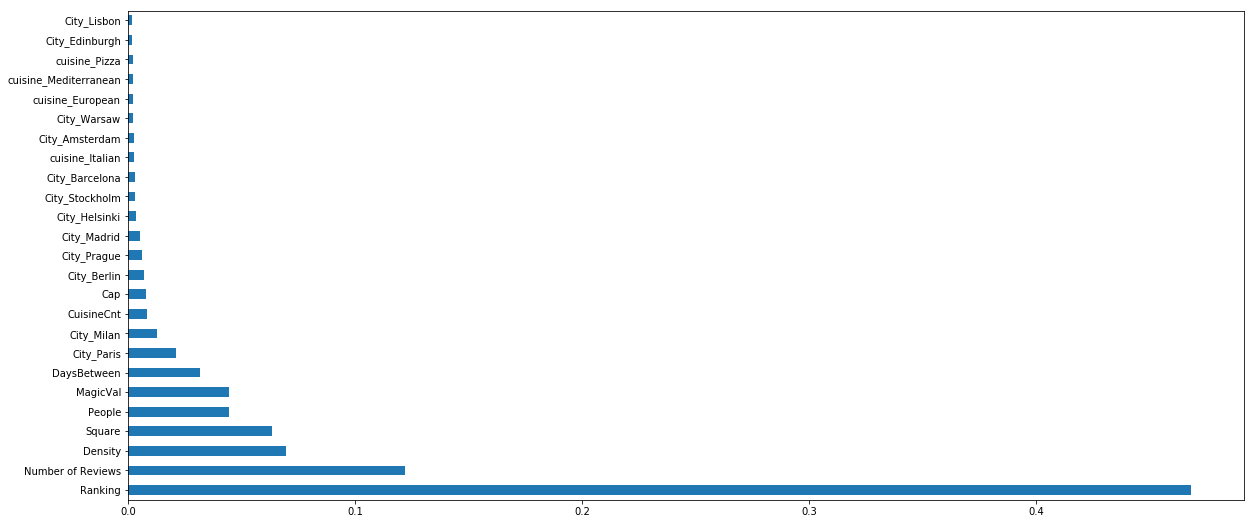

In [82]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (20,9)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data.columns

In [66]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [67]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
predict_submission

In [68]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.980
1,id_1,4.305
2,id_2,4.565
3,id_3,4.325
4,id_4,4.445
5,id_5,4.365
6,id_6,1.950
7,id_7,2.525
8,id_8,4.190
9,id_9,4.735


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
